In [5]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import admix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import dapgen
from os.path import join
import admix_genet_cor
import itertools
import submitit
from scipy.stats import pearsonr

In [6]:
GENO_DIR = (
    "/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01_dataset/out/aframr"
)
pfile = join(GENO_DIR, "imputed/chr1")
df_snp_info = pd.read_csv(pfile + ".snp_info", sep="\t").set_index("SNP")

df_snp_info = df_snp_info[
    df_snp_info.EUR_FREQ.between(0.005, 0.995)
    & df_snp_info.AFR_FREQ.between(0.005, 0.995)
]

In [3]:
def submit_simulate(hsq, causal_snps, out):
    df_rls = []
    for snp in causal_snps:
        df_rls.append(
            admix_genet_cor.simulate_hetero_assoc(pfile=pfile, hsq=hsq, causal_snp=snp)
        )
    df_rls = pd.concat(df_rls)
    df_rls["hsq"] = hsq
    df_rls.to_csv(out, sep="\t")
    return df_rls

In [4]:
hsq_list = [0.002, 0.005, 0.01, 0.025, 0.05]
np.random.seed(42)
df_params = []
for hsq in hsq_list:

    causal_snps = df_snp_info.sample(n=2000).index.values
    causal_snps_list = np.array_split(causal_snps, 80)
    df_params.append(
        pd.DataFrame(
            [(hsq, snps) for snps in causal_snps_list],
            columns=["hsq", "causal_snps"],
        )
    )
df_params = pd.concat(df_params)
df_params["chunk_i"] = np.arange(len(df_params))
df_params["out"] = df_params.apply(
    lambda x: f"out/simulated_gwas/chunk_{x.chunk_i}.tsv", axis=1
)

In [5]:
executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=40,
    memory_g=8,
    queue="highp",
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
    ],
)

jobs = executor.map_array(
    submit_simulate, df_params.hsq, df_params.causal_snps, df_params.out
)

In [5]:
df_rls = []
for f in df_params["out"]:
    if os.path.exists(f):
        df_rls.append(pd.read_csv(f, sep="\t"))
df_rls = pd.concat(df_rls)

In [6]:
df_rls_grouped = df_rls.groupby(["hsq", "assoc_pval_rank"])
df_plot = pd.concat(
    [
        df_rls_grouped.apply(lambda x: admix.data.lambda_gc(x["het_pval"])),
        df_rls_grouped.apply(lambda x: pearsonr(x["coef1"], x["coef2"])[0]),
        df_rls_grouped.apply(lambda x: np.mean(x["test_snp"] == x["causal_snp"])),
    ],
    axis=1,
)
df_plot.columns = ["lambda_gc", "pearsonr", "causal_prob"]
df_plot = df_plot.reset_index(drop=False)

Text(0, 0.5, '$\\lambda_{gc}$')

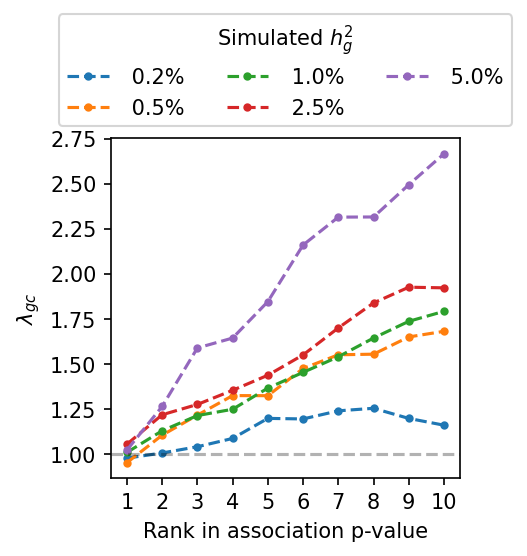

In [10]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
for hsq in df_plot.hsq.unique():
    df_tmp = df_plot[df_plot.hsq == hsq]
    ax.plot(
        df_tmp.assoc_pval_rank, df_tmp.lambda_gc, ".--", label=f"{hsq * 100 : .1f}%"
    )

ax.legend(loc="center", bbox_to_anchor=[0.5, 1.2], ncol=3, title="Simulated $h_g^2$")
ax.axhline(y=1, color="black", ls="--", alpha=0.3)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(1, 11).astype(str))
ax.set_xlabel("Rank in association p-value")
ax.set_ylabel("$\lambda_{gc}$")

Text(0, 0.5, "Pearson's correlation")

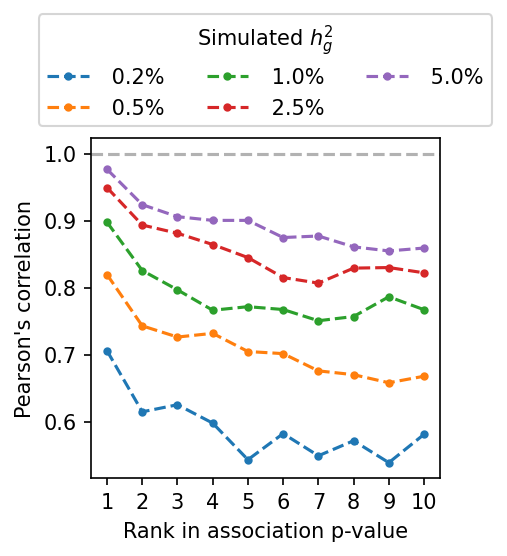

In [11]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
for hsq in df_plot.hsq.unique():
    df_tmp = df_plot[df_plot.hsq == hsq]
    ax.plot(df_tmp.assoc_pval_rank, df_tmp.pearsonr, ".--", label=f"{hsq * 100 : .1f}%")

ax.legend(loc="center", bbox_to_anchor=[0.5, 1.2], ncol=3, title="Simulated $h_g^2$")
ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(1, 11).astype(str))
ax.axhline(y=1, color="black", ls="--", alpha=0.3)
ax.set_xlabel("Rank in association p-value")
ax.set_ylabel("Pearson's correlation")

Text(0, 0.5, 'Probability of causal')

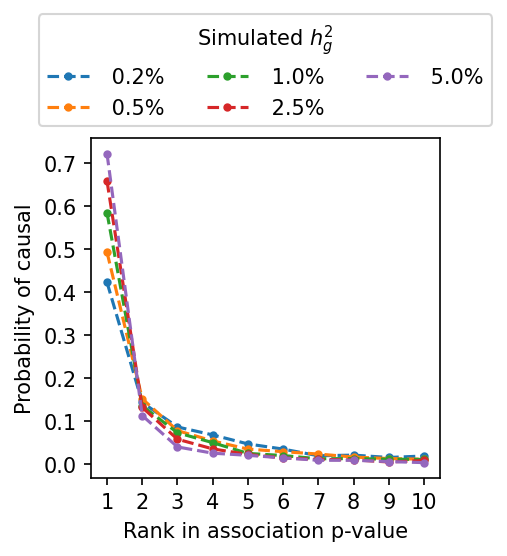

In [12]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
for hsq in df_plot.hsq.unique():
    df_tmp = df_plot[df_plot.hsq == hsq]
    ax.plot(
        df_tmp.assoc_pval_rank, df_tmp.causal_prob, ".--", label=f"{hsq * 100 : .1f}%"
    )

ax.legend(loc="center", bbox_to_anchor=[0.5, 1.2], ncol=3, title="Simulated $h_g^2$")
# ax.set_ylim(0, 1)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(1, 11).astype(str))
ax.set_xlabel("Rank in association p-value")
ax.set_ylabel("Probability of causal")

In [98]:
import statsmodels.api as sm
sm.OLS(df_rls["het_pval"], sm.add_constant(df_rls["assoc_pval_rank"])).fit().summary()